# 6.1 K fitting tool

//Mathieu: if you have data for K reduction as function of time, use this tool to fit the data and determine the A1, A2, A3, A4 parameters.

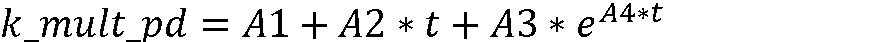

PFHpA data from article: 

*Modeling PFAS Removal Using Granular Activated Carbon for Full-Scale System Design*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def func(t, A1, A2, A3, A4):
    return A1+A2*t+A3*np.exp(A4*t)

with aid of ChatGPT:

Optimal parameter values:
A1: 0.51298520331305
A2: -2.690148126670144e-08
A3: 0.28297479686057875
A4: -3.908191380615166e-05


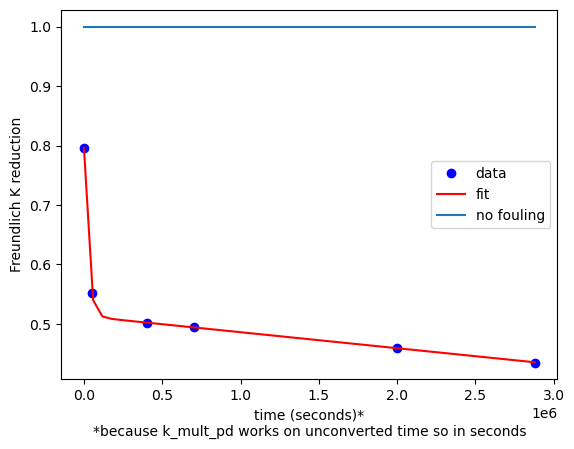

In [3]:
#//Mathieu: indicate how long simulation lasts
time_bounds = np.linspace(0, 2880000, 50) #time is not in days but in seconds, up to maximum (2880000 s = 2000 days)

############################################################################### insert your datapoints here:
time_data = np.array([0, 50000, 400000, 700000, 2000000, 2880000])
Kmult_data = np.array([0.79596, 0.551735552, 0.50207, 0.494, 0.46, 0.435])
###############################################################################

#//Mathieu: help the fit function by giving realistic values for fitting constanst A1-A4 in p0

plt.plot(time_data, Kmult_data, 'bo', label='data')
popt, pcov = curve_fit(func, time_data, Kmult_data, p0=[1,0,0.3,0])
popt
plt.plot(time_bounds, func(time_bounds, *popt), 'r-',
         label='fit')
popt, pcov = curve_fit(func, time_data, Kmult_data, p0=[1,0,0.3,0])

plt.plot(time_bounds, func(time_bounds, 1,0,0,0), label='no fouling') #without fouling

# Print the optimal parameter values
print("Optimal parameter values:")
print("A1:", popt[0])
print("A2:", popt[1])
print("A3:", popt[2])
print("A4:", popt[3])

plt.xlabel('time (seconds)*\n*because k_mult_pd works on unconverted time so in seconds')
plt.ylabel('Freundlich K reduction')
plt.legend()
plt.show()

## Feed PSDM_Kfit.py with fitted function

Ctrl+F: //Mathieu Kfittingtool:

In [4]:
## Import Required Packages
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import pylab as plt

import os
srt_dir = os.getcwd()

import PSDM_Kfit
os.chdir(srt_dir)

//Mathieu: self calculated b1 =  PFHpA    0.43565
dtype: float64
//Mathieu: self calculated b2 =  PFHpA    0.360309
dtype: float64


In [5]:
fn = '6.1_Input_PFHpA.xlsx'

chem_data = PSDM_Kfit.process_input_data(fn, sheet_name='Properties') 
k_data = pd.read_excel(fn, sheet_name='Kdata',index_col=0) # K & 1/n data

raw_data, column_info,\
compounds, carbons, = PSDM_Kfit.process_input_file(fn,\
                                               data_sheet='data',\
                                               column_sheet='columnSpecs'
                                              )

In [6]:
raw_data, column_info,\
compounds, carbons, = PSDM_Kfit.process_input_file(fn,\
                                               data_sheet='data_variable',\
                                               column_sheet='columnSpecs'
                                              )

PFHpA
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  0.51298520331305
rk2:  -2.690148126670144e-08
rk3:  0.28297479686057875
rk4:  -3.908191380615166e-05
//Mathieu: fouling parameters:
a1:  1.0
a2:  0.0
a3:  0.0
a4:  0.0
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  1
rk2:  0
rk3:  0
rk4:  0
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  0.512787
rk2:  -2.679248e-08
rk3:  0.283173
rk4:  -3.9e-05


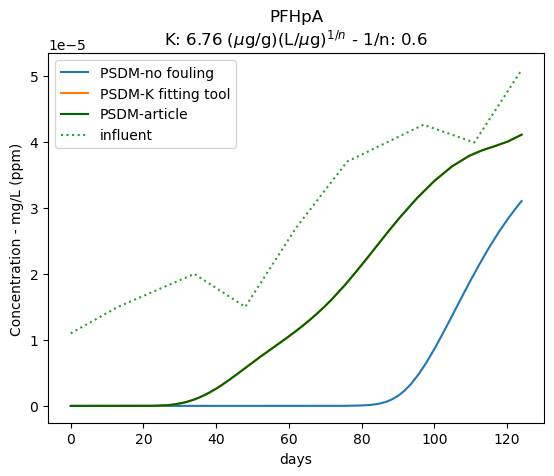

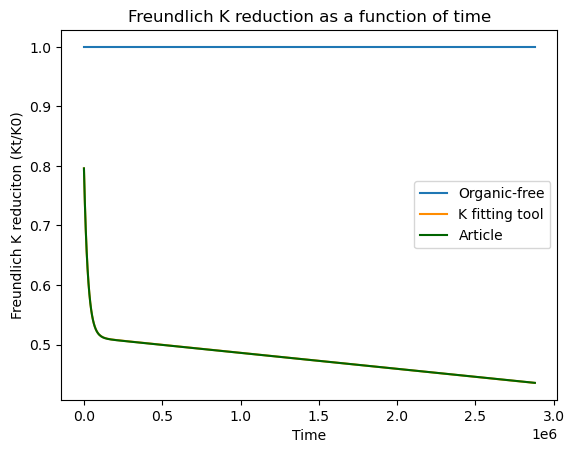

In [7]:
#//Mathieu: get A1, A2, A3, A4 from fitted K(t) function

A1_kfit = popt[0]
A2_kfit = popt[1]
A3_kfit = popt[2]
A4_kfit = popt[3]

#//Mathieu: the column with K fitting tool still needed (chem_type) and water_type somehow, otherwise strange BTC*
chem_type = 'PFAS'
water_type = 'Rhine'

# *reason as I can derive: because of water_type, PSDM_Kfit has to know if organic-free or not

for comp in compounds:
    print(comp)
    
    #//Mathieu: column is with fitted parameters
    column = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,A1_kfit,A2_kfit,A3_kfit,A4_kfit,'',  #extra input to PSDM object
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   #chem_type=chem_type,
                   water_type=water_type, #still needed to know if organic-free or not
                   optimize=False
                   )
    
    column.test_range = np.array([k_data[comp]['K']])
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    #//Mathieu: column2 is without fouling, because "1,0,0,0"
    column2 = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,1,0,0,0,'',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   optimize=False
                   )
    
    column2.test_range = np.array([k_data[comp]['K']])
    column2.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results2 = column2.run_psdm_kfit(comp)  
    
    #//Mathieu: column3 is BTC article, because values "0.512787,-2.679248e-08,0.283173,-0.000039" derived from that simulation
    column3 = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,0.512787,-2.679248e-08,0.283173,-0.000039,'',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   #chem_type=chem_type,
                   water_type=water_type, #still needed to know if organic-free or not
                   optimize=False
                   )
    
    column3.test_range = np.array([k_data[comp]['K']])
    column3.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results3 = column3.run_psdm_kfit(comp)  
    
    ## plotting results 
    #units are converted from ug/L to mg/L 
    plt.plot(results2.index, 
             results2.values/1000., 
             label='PSDM-no fouling')    
    plt.plot(results.index, 
             results.values/1000., 
             label='PSDM-K fitting tool')
    plt.plot(results3.index, 
             results3.values/1000., 
             label='PSDM-article',
             color='darkgreen')  
    (raw_data[column.influent][comp]/1000.).plot.line(label='influent',linestyle=':')
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(_k,2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(_xn,3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example2.png', dpi=300)
    plt.show
    
    plt.figure()
    plt.plot(column2.K_time, 
             column2.K_mult_time,
             label='Organic-free')     
    plt.plot(column.K_time, 
             column.K_mult_time,
             label='K fitting tool',
             color='darkorange')
    
    #Compare K fitting tool with BTC article (darkgreen, where K reduction is calculated)
    
    plt.plot(column3.K_time, 
             column3.K_mult_time,
             label='Article',
             color='darkgreen') 
    plt.legend()
    plt.title('Freundlich K reduction as a function of time')  # Title of the plot    
    plt.xlabel('Time')  # Label for the x-axis
    plt.ylabel('Freundlich K reduciton (Kt/K0)')  # Label for the y-axis
    plt.grid(False)
    plt.show()  # Display the plot  

//Mathieu: it can be seen that the function from the K fitting tool was well implemented in the column simulation (PSDM_Kfit Ctrl+F: //Mathieu Kfittingtool)

## K reduction time axis adjustment

Same K reduction graph as article again, adjust time axis to days (124 and not max of 2000)

Optimal parameter values:
rk1: 0.5127870007727449
rk2: -2.6792486008322504e-08
rk3: 0.28317299920450245
rk4: -3.900000005248926e-05


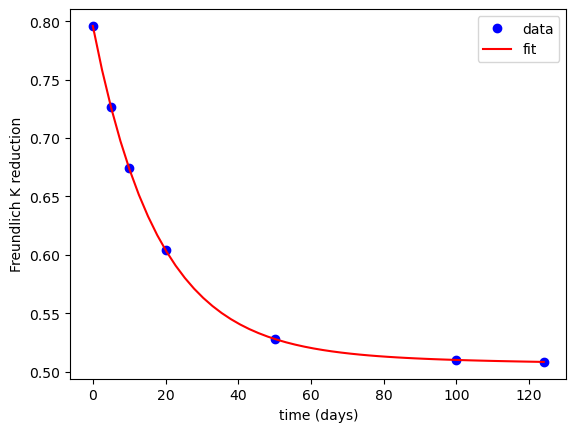

In [8]:
time_bounds = np.linspace(0, 178560, 50) #time still in seconds because simulation calculates in seconds

############################################################################### insert your datapoints here:
time_data = np.array([0, 7200, 14400, 28800, 72000, 144000, 178560]) # calculates in seconds
Kmult_data = np.array([0.79596, 0.726440498, 0.673893578, 0.604113818, 0.527940501, 0.509959397, 0.508270663]) # these calculated from article simulation
###############################################################################

#//Mathieu: help the fit function by giving realistic values for fitting constanst A1-A4 in p0

plt.plot(time_data/(24*60), Kmult_data, 'bo', label='data')
popt, pcov = curve_fit(func, time_data, Kmult_data, p0=[1,0,0.3,0])
popt
plt.plot(time_bounds/(24*60), func(time_bounds, *popt), 'r-',
         label='fit')
popt, pcov = curve_fit(func, time_data, Kmult_data, p0=[1,0,0.3,0])

# Print the optimal parameter values
print("Optimal parameter values:")
print("rk1:", popt[0])
print("rk2:", popt[1])
print("rk3:", popt[2])
print("rk4:", popt[3])

plt.xlabel('time (days)')
plt.ylabel('Freundlich K reduction')
plt.legend()
plt.show()

//Mathieu: So only this part of the K reduction function is needed because simulation only lasts 124 days

PFHpA
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  0.5127870007727449
rk2:  -2.6792486008322504e-08
rk3:  0.28317299920450245
rk4:  -3.900000005248926e-05
//Mathieu: fouling parameters:
a1:  1.0
a2:  0.0
a3:  0.0
a4:  0.0
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  1
rk2:  0
rk3:  0
rk4:  0
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  0.512787
rk2:  -2.679248e-08
rk3:  0.283173
rk4:  -3.9e-05


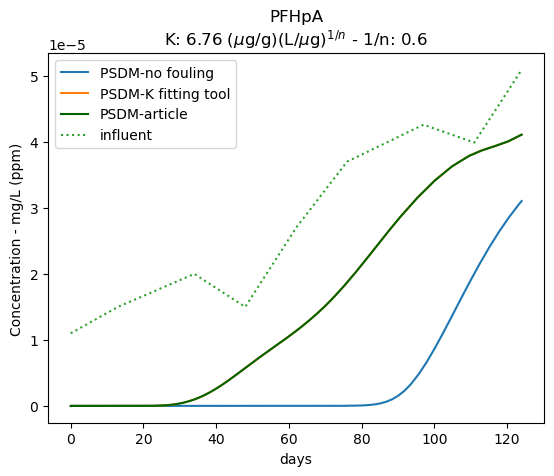

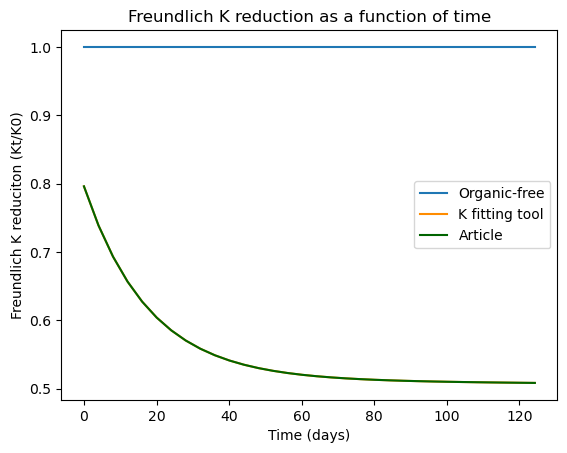

In [9]:
#//Mathieu: get A1, A2, A3, A4 from fitted K(t) function

A1_kfit = popt[0]
A2_kfit = popt[1]
A3_kfit = popt[2]
A4_kfit = popt[3]

#//Mathieu: the column with K fitting tool still needed (chem_type) and water_type somehow, otherwise strange BTC
chem_type = 'PFAS'
water_type = 'Rhine'

# *reason as I can derive: because of water_type, PSDM_Kfit has to know if organic-free or not

for comp in compounds:
    print(comp)
    
    #//Mathieu: column is with fitted parameters
    column = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,A1_kfit,A2_kfit,A3_kfit,A4_kfit,'',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   #chem_type=chem_type,
                   water_type=water_type, #still needed to know if organic-free or not                         
                   optimize=False
                   )
    
    column.test_range = np.array([k_data[comp]['K']])
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    #//Mathieu: column2 is without fouling, because "1,0,0,0"
    column2 = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,1,0,0,0,'',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   optimize=False
                   )
    
    column2.test_range = np.array([k_data[comp]['K']])
    column2.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results2 = column2.run_psdm_kfit(comp)  
    
    #//Mathieu: column3 is BTC article, because values "0.512787,-2.679248e-08,0.283173,-0.000039" derived from that simulation
    column3 = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,0.512787,-2.679248e-08,0.283173,-0.000039,'',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   #chem_type=chem_type,
                   water_type=water_type, #still needed to know if organic-free or not
                   optimize=False
                   )
    
    column3.test_range = np.array([k_data[comp]['K']])
    column3.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results3 = column3.run_psdm_kfit(comp)  
    
    ## plotting results 
    #units are converted from ug/L to mg/L 
    plt.plot(results2.index, 
             results2.values/1000., 
             label='PSDM-no fouling')    
    plt.plot(results.index, 
             results.values/1000., 
             label='PSDM-K fitting tool')
    plt.plot(results3.index, 
             results3.values/1000., 
             label='PSDM-article',
             color='darkgreen')  
    (raw_data[column.influent][comp]/1000.).plot.line(label='influent',linestyle=':')
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(_k,2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(_xn,3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example2.png', dpi=300)
    plt.show
    
    days_of_operation_column = 124
    K_time = np.array(column.K_time)
    K_time_days = K_time/(60*24)
    index = np.argmax(K_time_days >= days_of_operation_column)
    
    plt.figure()
    plt.plot(K_time_days[:index+1], 
             column2.K_mult_time[:index+1],
             label='Organic-free')     
    plt.plot(K_time_days[:index+1], 
             column.K_mult_time[:index+1],
             label='K fitting tool',
             color='darkorange')
    
    #Compare K fitting tool with BTC article (darkgreen, where K reduction is calculated)
    
    plt.plot(K_time_days[:index+1], 
             column3.K_mult_time[:index+1],
             label='Article',
             color='darkgreen') 
    plt.legend()
    plt.title('Freundlich K reduction as a function of time')  # Title of the plot    
    plt.xlabel('Time (days)')  # Label for the x-axis
    plt.ylabel('Freundlich K reduciton (Kt/K0)')  # Label for the y-axis
    plt.grid(False)
    plt.show()  # Display the plot  

## What if K reduction not time dependent

Optimal parameter values:
A1: 0.6082709998613735
A2: 1.385331675710741e-21
A3: -0.09999999986137346
A4: 1.3292068605305138e-20


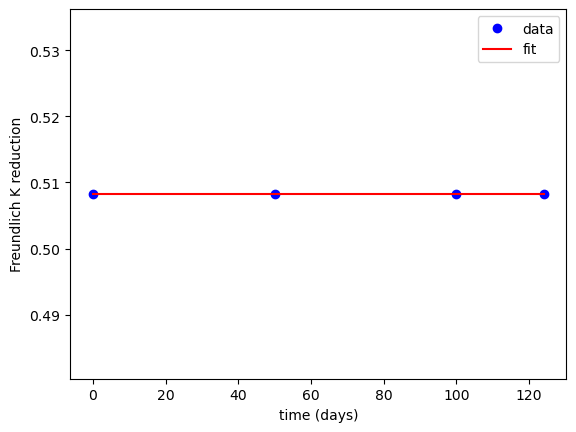

In [10]:
time_bounds = np.linspace(0, 178560, 50) #time still in seconds because simulation calculates in seconds

############################################################################### insert your datapoints here:
time_data = np.array([0, 72000, 144000, 178560]) # calculates in seconds
Kmult_data = np.array([0.508271, 0.508271, 0.508271, 0.508271]) # constant
###############################################################################

#//Mathieu: help the fit function by giving realistic values for fitting constanst A1-A4 in p0

plt.plot(time_data/(24*60), Kmult_data, 'bo', label='data')
popt, pcov = curve_fit(func, time_data, Kmult_data, p0=[1,0,0,0])
popt
plt.plot(time_bounds/(24*60), func(time_bounds, *popt), 'r-',
         label='fit')
popt, pcov = curve_fit(func, time_data, Kmult_data, p0=[1,0,0,0])

# Print the optimal parameter values
print("Optimal parameter values:")
print("A1:", popt[0])
print("A2:", popt[1])
print("A3:", popt[2])
print("A4:", popt[3])

plt.xlabel('time (days)')
plt.ylabel('Freundlich K reduction')
plt.legend()
plt.show()

PFHpA
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  0.6082709998613735
rk2:  1.385331675710741e-21
rk3:  -0.09999999986137346
rk4:  1.3292068605305138e-20
//Mathieu: fouling parameters:
a1:  1.0
a2:  0.0
a3:  0.0
a4:  0.0
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  1
rk2:  0
rk3:  0
rk4:  0
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  0.512787
rk2:  -2.679248e-08
rk3:  0.283173
rk4:  -3.9e-05


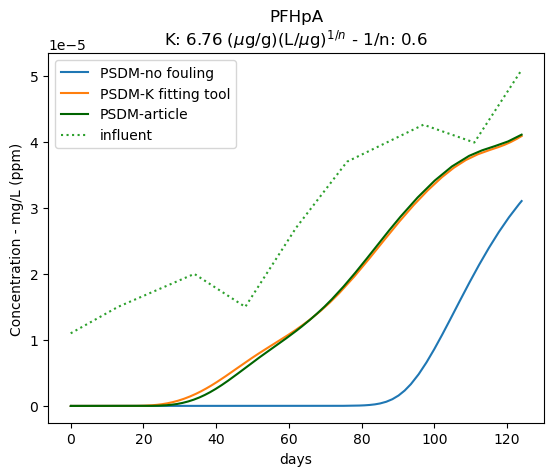

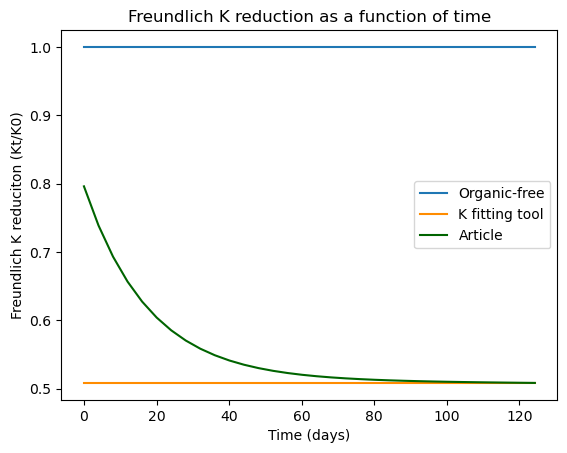

In [11]:
#//Mathieu: get A1, A2, A3, A4 from fitted K(t) function

A1_kfit = popt[0]
A2_kfit = popt[1]
A3_kfit = popt[2]
A4_kfit = popt[3]

#//Mathieu: the column with K fitting tool still needed chem_type and water_type somehow, otherwise strange BTC
chem_type = 'PFAS'
water_type = 'Rhine'

# *reason as I can derive: because of water_type, PSDM_Kfit has to know if organic-free or not

for comp in compounds:
    print(comp)
    
    #//Mathieu: column is with fitted parameters
    column = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,A1_kfit,A2_kfit,A3_kfit,A4_kfit,'',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   #chem_type=chem_type,
                   water_type=water_type, #still needed to know if organic-free or not                         
                   optimize=False
                   )
    
    column.test_range = np.array([k_data[comp]['K']])
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    #//Mathieu: column2 is without fouling, because "1,0,0,0"
    column2 = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,1,0,0,0,'',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   optimize=False
                   )
    
    column2.test_range = np.array([k_data[comp]['K']])
    column2.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results2 = column2.run_psdm_kfit(comp)  
    
    #//Mathieu: column3 is BTC article, because values "0.512787,-2.679248e-08,0.283173,-0.000039" derived from that simulation
    column3 = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,0.512787,-2.679248e-08,0.283173,-0.000039,'',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   #chem_type=chem_type,
                   water_type=water_type, #still needed to know if organic-free or not
                   optimize=False
                   )
    
    column3.test_range = np.array([k_data[comp]['K']])
    column3.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results3 = column3.run_psdm_kfit(comp)  
    
    ## plotting results 
    #units are converted from ug/L to mg/L 
    plt.plot(results2.index, 
             results2.values/1000., 
             label='PSDM-no fouling')    
    plt.plot(results.index, 
             results.values/1000., 
             label='PSDM-K fitting tool')
    plt.plot(results3.index, 
             results3.values/1000., 
             label='PSDM-article',
             color='darkgreen')  
    (raw_data[column.influent][comp]/1000.).plot.line(label='influent',linestyle=':')
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(_k,2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(_xn,3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example2.png', dpi=300)
    plt.show
    
    days_of_operation_column = 124
    K_time = np.array(column.K_time)
    K_time_days = K_time/(60*24)
    index = np.argmax(K_time_days >= days_of_operation_column)
    
    plt.figure()
    plt.plot(K_time_days[:index+1], 
             column2.K_mult_time[:index+1],
             label='Organic-free')     
    plt.plot(K_time_days[:index+1], 
             column.K_mult_time[:index+1],
             label='K fitting tool',
             color='darkorange')
    
    #Compare K fitting tool with BTC article (darkgreen, where K reduction is calculated)
    
    plt.plot(K_time_days[:index+1], 
             column3.K_mult_time[:index+1],
             label='Article',
             color='darkgreen') 
    plt.legend()
    plt.title('Freundlich K reduction as a function of time')  # Title of the plot    
    plt.xlabel('Time (days)')  # Label for the x-axis
    plt.ylabel('Freundlich K reduciton (Kt/K0)')  # Label for the y-axis
    plt.grid(False)
    plt.show()  # Display the plot  

## Now constant influent

In [12]:
raw_data, column_info,\
compounds, carbons, = PSDM_Kfit.process_input_file(fn,\
                                               data_sheet='data',\
                                               column_sheet='columnSpecs'
                                              )

PFHpA
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  0.6082709998613735
rk2:  1.385331675710741e-21
rk3:  -0.09999999986137346
rk4:  1.3292068605305138e-20
//Mathieu: fouling parameters:
a1:  1.0
a2:  0.0
a3:  0.0
a4:  0.0
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  1
rk2:  0
rk3:  0
rk4:  0
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  0.512787
rk2:  -2.679248e-08
rk3:  0.283173
rk4:  -3.9e-05


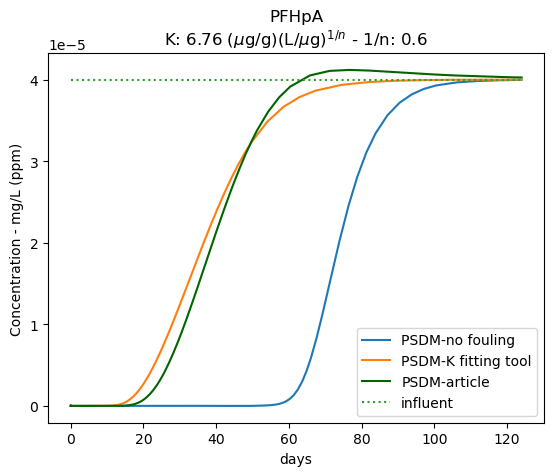

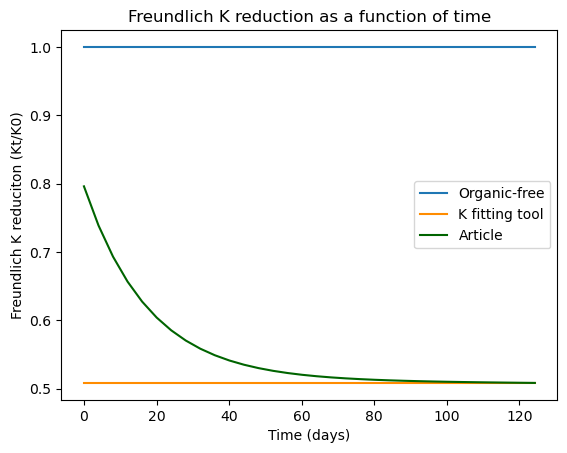

In [13]:
#//Mathieu: get A1, A2, A3, A4 from fitted K(t) function

A1_kfit = popt[0]
A2_kfit = popt[1]
A3_kfit = popt[2]
A4_kfit = popt[3]

#//Mathieu: the column with K fitting tool still needed chem_type and water_type somehow, otherwise strange BTC
chem_type = 'PFAS'
water_type = 'Rhine'

# *reason as I can derive: because of water_type, PSDM_Kfit has to know if organic-free or not

for comp in compounds:
    print(comp)
    
    #//Mathieu: column is with fitted parameters
    column = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,A1_kfit,A2_kfit,A3_kfit,A4_kfit,'',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   #chem_type=chem_type,
                   water_type=water_type, #still needed to know if organic-free or not                         
                   optimize=False
                   )
    
    column.test_range = np.array([k_data[comp]['K']])
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    #//Mathieu: column2 is without fouling, because "1,0,0,0"
    column2 = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,1,0,0,0,'',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   optimize=False
                   )
    
    column2.test_range = np.array([k_data[comp]['K']])
    column2.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results2 = column2.run_psdm_kfit(comp)  
    
    #//Mathieu: column3 is BTC article, because values "0.512787,-2.679248e-08,0.283173,-0.000039" derived from that simulation
    column3 = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,0.512787,-2.679248e-08,0.283173,-0.000039,'',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   #chem_type=chem_type,
                   water_type=water_type, #still needed to know if organic-free or not
                   optimize=False
                   )
    
    column3.test_range = np.array([k_data[comp]['K']])
    column3.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results3 = column3.run_psdm_kfit(comp)  
    
    ## plotting results 
    #units are converted from ug/L to mg/L 
    plt.plot(results2.index, 
             results2.values/1000., 
             label='PSDM-no fouling')    
    plt.plot(results.index, 
             results.values/1000., 
             label='PSDM-K fitting tool')
    plt.plot(results3.index, 
             results3.values/1000., 
             label='PSDM-article',
             color='darkgreen')  
    (raw_data[column.influent][comp]/1000.).plot.line(label='influent',linestyle=':')
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(_k,2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(_xn,3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example2.png', dpi=300)
    plt.show
    
    days_of_operation_column = 124
    K_time = np.array(column.K_time)
    K_time_days = K_time/(60*24)
    index = np.argmax(K_time_days >= days_of_operation_column)
    
    plt.figure()
    plt.plot(K_time_days[:index+1], 
             column2.K_mult_time[:index+1],
             label='Organic-free')     
    plt.plot(K_time_days[:index+1], 
             column.K_mult_time[:index+1],
             label='K fitting tool',
             color='darkorange')
    
    #Compare K fitting tool with BTC article (darkgreen, where K reduction is calculated)
    
    plt.plot(K_time_days[:index+1], 
             column3.K_mult_time[:index+1],
             label='Article',
             color='darkgreen') 
    plt.legend()
    plt.title('Freundlich K reduction as a function of time')  # Title of the plot    
    plt.xlabel('Time (days)')  # Label for the x-axis
    plt.ylabel('Freundlich K reduciton (Kt/K0)')  # Label for the y-axis
    plt.grid(False)
    plt.show()  # Display the plot  

In [14]:
column_info

,F400
rad,0.0513
flrt,984.207064
epor,0.641
psdfr,5.0
rhop,0.803
rhof,0.62
L,120.0
wt,4349.950828
diam,10.155936
tortu,1.0


## Small test: compare with weight reduction fouling approach (same reduction) see column 4

PFHpA
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  0.6082709998613735
rk2:  1.385331675710741e-21
rk3:  -0.09999999986137346
rk4:  1.3292068605305138e-20
//Mathieu: fouling parameters:
a1:  1.0
a2:  0.0
a3:  0.0
a4:  0.0
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  1
rk2:  0
rk3:  0
rk4:  0
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  0.512787
rk2:  -2.679248e-08
rk3:  0.283173
rk4:  -3.9e-05
//Mathieu: fouling parameters:
a1:  1.0
a2:  0.0
a3:  0.0
a4:  0.0
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  1
rk2:  0
rk3:  0
rk4:  0


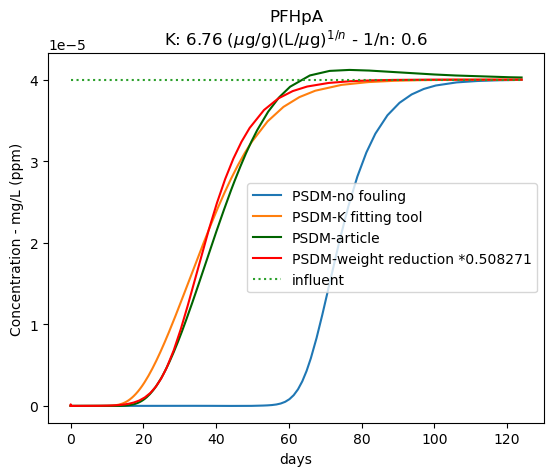

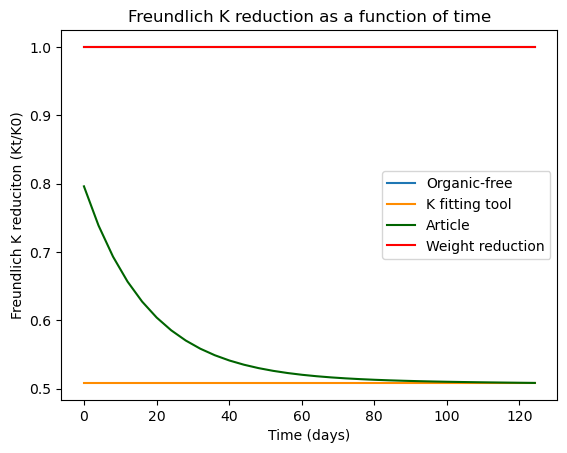

In [15]:
#//Mathieu: get A1, A2, A3, A4 from fitted K(t) function

A1_kfit = popt[0]
A2_kfit = popt[1]
A3_kfit = popt[2]
A4_kfit = popt[3]

#//Mathieu: the column with K fitting tool still needed chem_type and water_type somehow, otherwise strange BTC
chem_type = 'PFAS'
water_type = 'Rhine'

# *reason as I can derive: because of water_type, PSDM_Kfit has to know if organic-free or not

for comp in compounds:
    print(comp)
    
    #//Mathieu: column is with fitted parameters
    column = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,A1_kfit,A2_kfit,A3_kfit,A4_kfit,'none',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   #chem_type=chem_type,
                   water_type=water_type, #still needed to know if organic-free or not                         
                   optimize=False
                   )
    
    column.test_range = np.array([k_data[comp]['K']])
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    #//Mathieu: column2 is without fouling, because "1,0,0,0"
    column2 = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,1,0,0,0,'none',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   optimize=False
                   )
    
    column2.test_range = np.array([k_data[comp]['K']])
    column2.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results2 = column2.run_psdm_kfit(comp)  
    
    #//Mathieu: column3 is BTC article, because values "0.512787,-2.679248e-08,0.283173,-0.000039" derived from that simulation
    column3 = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,0.512787,-2.679248e-08,0.283173,-0.000039,'none',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   #chem_type=chem_type,
                   water_type=water_type, #still needed to know if organic-free or not
                   optimize=False
                   )
    
    column3.test_range = np.array([k_data[comp]['K']])
    column3.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results3 = column3.run_psdm_kfit(comp)  
    
    #//Mathieu: column4 is weight reduction and no K reduction, because "1,0,0,0"
    column4 = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,1,0,0,0, #no K reduction
                   'weightReductionTrue',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   optimize=False
                   )
    
    column4.test_range = np.array([k_data[comp]['K']])
    column4.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results4 = column4.run_psdm_kfit(comp)  
    
    ## plotting results 
    #units are converted from ug/L to mg/L 
    plt.plot(results2.index, 
             results2.values/1000., 
             label='PSDM-no fouling')    
    plt.plot(results.index, 
             results.values/1000., 
             label='PSDM-K fitting tool')
    plt.plot(results3.index, 
             results3.values/1000., 
             label='PSDM-article',
             color='darkgreen')  
    plt.plot(results4.index, 
             results4.values/1000., 
             label='PSDM-weight reduction *0.508271',
             color='red')  
    (raw_data[column.influent][comp]/1000.).plot.line(label='influent',linestyle=':')
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(_k,2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(_xn,3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example2.png', dpi=300)
    plt.show
    
    days_of_operation_column = 124
    K_time = np.array(column.K_time)
    K_time_days = K_time/(60*24)
    index = np.argmax(K_time_days >= days_of_operation_column)
    
    plt.figure()
    plt.plot(K_time_days[:index+1], 
             column2.K_mult_time[:index+1],
             label='Organic-free')     
    plt.plot(K_time_days[:index+1], 
             column.K_mult_time[:index+1],
             label='K fitting tool',
             color='darkorange')
    
    #Compare K fitting tool with BTC article (darkgreen, where K reduction is calculated)
    
    plt.plot(K_time_days[:index+1], 
             column3.K_mult_time[:index+1],
             label='Article',
             color='darkgreen') 
    
    #Check if Column4 with weight reduction has no K reduction
    
    plt.plot(K_time_days[:index+1], 
             column4.K_mult_time[:index+1],
             label='Weight reduction',
             color='red')  
    
    plt.legend()
    plt.title('Freundlich K reduction as a function of time')  # Title of the plot    
    plt.xlabel('Time (days)')  # Label for the x-axis
    plt.ylabel('Freundlich K reduciton (Kt/K0)')  # Label for the y-axis
    plt.grid(False)
    plt.show()  # Display the plot  

In [16]:
column.wt,column2.wt,column3.wt,column4.wt

(4349.9508283000005,
 4349.9508283000005,
 4349.9508283000005,
 2210.9538574508697)

//Mathieu: FOULING: through this short test it could be seen that the K reduction approach (see later) and the weight reduction approach are not exactly equivalent, although they both have a constant reduction of 0.508271. The carbon weight reduction fouling approach resulted in a steeper BTC.

## Catch up sudden K increase

From reference article: *Simulating the performance of fixed-bed granular activated carbon adsorbers Removal of synthetic organic chemicals in the presence of background organic matter - 2005*

it can be seen from reference data that there is mostly a sudden increase of K. In the PFHpA simulation from the PFAS pilot plant (reference article), the simulation only lasts 18 weeks (124 days / 7) 

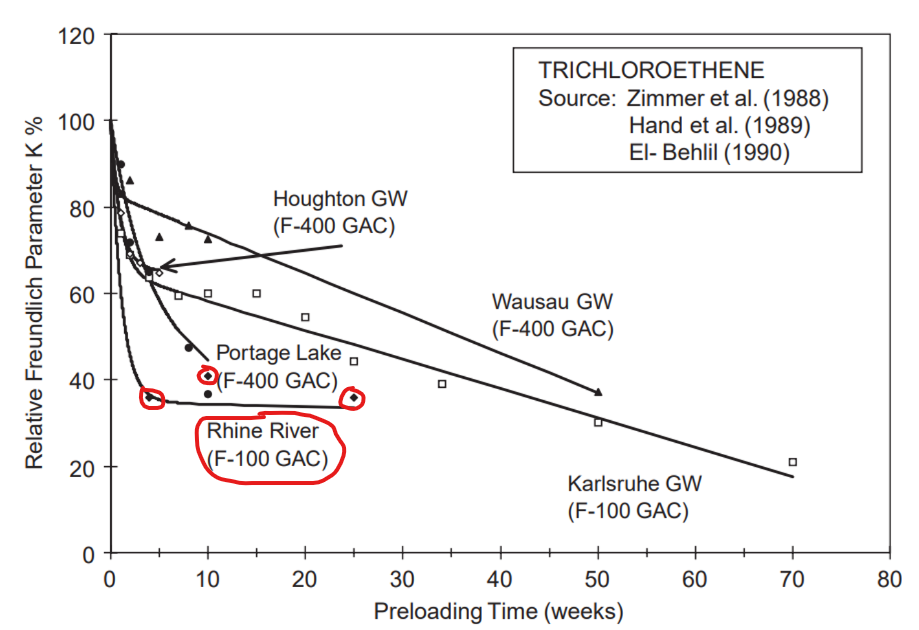

In [17]:
raw_data, column_info,\
compounds, carbons, = PSDM_Kfit.process_input_file(fn,\
                                               data_sheet='data_variable',\
                                               column_sheet='columnSpecs'
                                              )

Optimal parameter values:
rk1: 0.4732924471523238
rk2: 3.983373082225492e-07
rk3: 0.3222187441560593
rk4: -3.475632501903665e-05


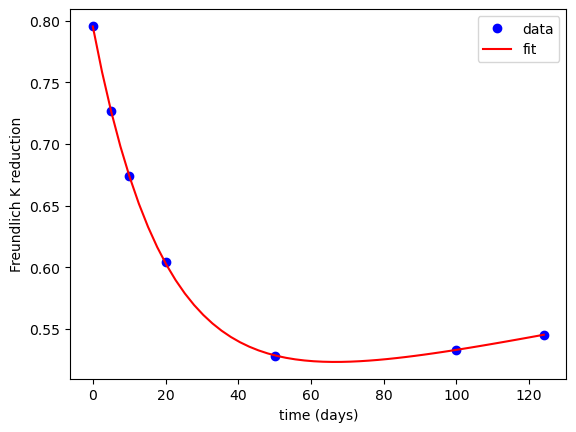

In [18]:
time_bounds = np.linspace(0, 178560, 50) #time still in seconds because simulation calculates in seconds

############################################################################### insert your datapoints here:
time_data = np.array([0, 7200, 14400, 28800, 72000, 144000, 178560]) # calculates in seconds
Kmult_data = np.array([0.79596, 0.726440498, 0.673893578, 0.604113818, 0.527940501, 0.533, 0.545]) #Catch up K increase now
###############################################################################

#//Mathieu: help the fit function by giving realistic values for fitting constanst A1-A4 in p0

plt.plot(time_data/(24*60), Kmult_data, 'bo', label='data')
popt, pcov = curve_fit(func, time_data, Kmult_data, p0=[1,0,0.3,0])
popt
plt.plot(time_bounds/(24*60), func(time_bounds, *popt), 'r-',
         label='fit')
popt, pcov = curve_fit(func, time_data, Kmult_data, p0=[1,0,0.3,0])

# Print the optimal parameter values
print("Optimal parameter values:")
print("rk1:", popt[0])
print("rk2:", popt[1])
print("rk3:", popt[2])
print("rk4:", popt[3])

plt.xlabel('time (days)')
plt.ylabel('Freundlich K reduction')
plt.legend()
plt.show()

//Mathieu: So only this part of the K reduction function is needed because simulation only lasts 124 days

PFHpA
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  0.4732924471523238
rk2:  3.983373082225492e-07
rk3:  0.3222187441560593
rk4:  -3.475632501903665e-05
//Mathieu: fouling parameters:
a1:  1.0
a2:  0.0
a3:  0.0
a4:  0.0
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  1
rk2:  0
rk3:  0
rk4:  0
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  0.512787
rk2:  -2.679248e-08
rk3:  0.283173
rk4:  -3.9e-05


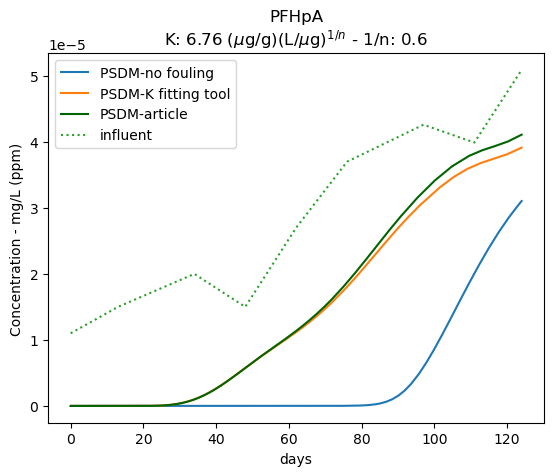

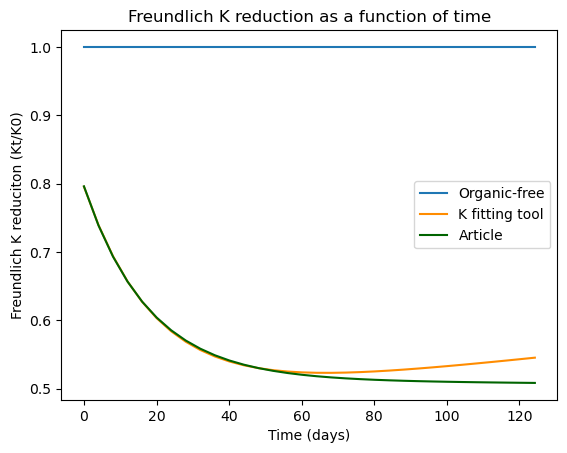

In [19]:
#//Mathieu: get A1, A2, A3, A4 from fitted K(t) function

A1_kfit = popt[0]
A2_kfit = popt[1]
A3_kfit = popt[2]
A4_kfit = popt[3]

#//Mathieu: the column with K fitting tool still needed (chem_type) and water_type somehow, otherwise strange BTC
chem_type = 'PFAS'
water_type = 'Rhine'

# *reason as I can derive: because of water_type, PSDM_Kfit has to know if organic-free or not

for comp in compounds:
    print(comp)
    
    #//Mathieu: column is with fitted parameters
    column = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,A1_kfit,A2_kfit,A3_kfit,A4_kfit,'',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   #chem_type=chem_type,
                   water_type=water_type, #still needed to know if organic-free or not                         
                   optimize=False
                   )
    
    column.test_range = np.array([k_data[comp]['K']])
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    #//Mathieu: column2 is without fouling, because "1,0,0,0"
    column2 = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,1,0,0,0,'',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   optimize=False
                   )
    
    column2.test_range = np.array([k_data[comp]['K']])
    column2.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results2 = column2.run_psdm_kfit(comp)  
    
    #//Mathieu: column3 is BTC article, because values "0.512787,-2.679248e-08,0.283173,-0.000039" derived from that simulation
    column3 = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,0.512787,-2.679248e-08,0.283173,-0.000039,'',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   #chem_type=chem_type,
                   water_type=water_type, #still needed to know if organic-free or not
                   optimize=False
                   )
    
    column3.test_range = np.array([k_data[comp]['K']])
    column3.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results3 = column3.run_psdm_kfit(comp)  
    
    ## plotting results 
    #units are converted from ug/L to mg/L 
    plt.plot(results2.index, 
             results2.values/1000., 
             label='PSDM-no fouling')    
    plt.plot(results.index, 
             results.values/1000., 
             label='PSDM-K fitting tool')
    plt.plot(results3.index, 
             results3.values/1000., 
             label='PSDM-article',
             color='darkgreen')  
    (raw_data[column.influent][comp]/1000.).plot.line(label='influent',linestyle=':')
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(_k,2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(_xn,3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example2.png', dpi=300)
    plt.show
    
    days_of_operation_column = 124
    K_time = np.array(column.K_time)
    K_time_days = K_time/(60*24)
    index = np.argmax(K_time_days >= days_of_operation_column)
    
    plt.figure()
    plt.plot(K_time_days[:index+1], 
             column2.K_mult_time[:index+1],
             label='Organic-free')     
    plt.plot(K_time_days[:index+1], 
             column.K_mult_time[:index+1],
             label='K fitting tool',
             color='darkorange')
    
    #Compare K fitting tool with BTC article (darkgreen, where K reduction is calculated)
    
    plt.plot(K_time_days[:index+1], 
             column3.K_mult_time[:index+1],
             label='Article',
             color='darkgreen') 
    plt.legend()
    plt.title('Freundlich K reduction as a function of time')  # Title of the plot    
    plt.xlabel('Time (days)')  # Label for the x-axis
    plt.ylabel('Freundlich K reduciton (Kt/K0)')  # Label for the y-axis
    plt.grid(False)
    plt.show()  # Display the plot  

//Mathieu: The fitted K curve was after some time higher (less reduction due to fouling) than in the article simulation. This resulted in a BTC that moved slightly to the right which makes sense

## Catch up sudden K increase with constant effluent

In [20]:
raw_data, column_info,\
compounds, carbons, = PSDM_Kfit.process_input_file(fn,\
                                               data_sheet='data',\
                                               column_sheet='columnSpecs'
                                              )

PFHpA
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  0.4732924471523238
rk2:  3.983373082225492e-07
rk3:  0.3222187441560593
rk4:  -3.475632501903665e-05
//Mathieu: fouling parameters:
a1:  1.0
a2:  0.0
a3:  0.0
a4:  0.0
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  1
rk2:  0
rk3:  0
rk4:  0
//Mathieu: fouling parameters:
a1:  0.35
a2:  -6.15e-08
a3:  0.65
a4:  -8.93e-05
b1:  PFHpA    1.0
dtype: float64
b2:  PFHpA    0.0
dtype: float64
rk1:  0.512787
rk2:  -2.679248e-08
rk3:  0.283173
rk4:  -3.9e-05


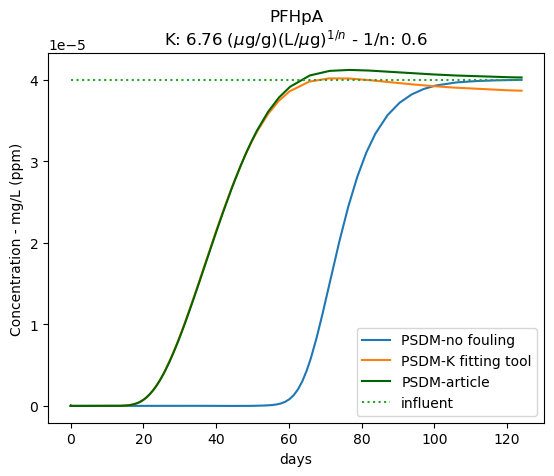

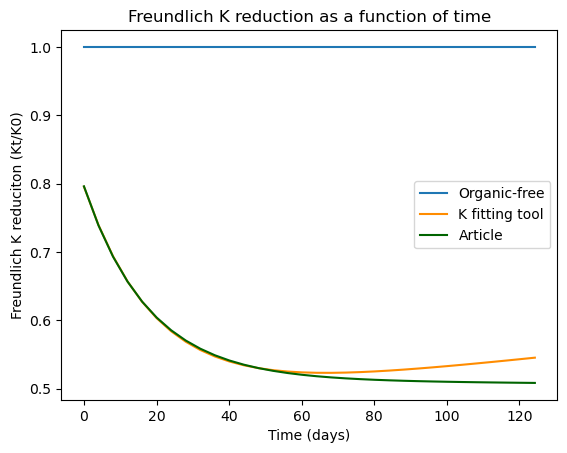

In [21]:
#//Mathieu: get A1, A2, A3, A4 from fitted K(t) function

A1_kfit = popt[0]
A2_kfit = popt[1]
A3_kfit = popt[2]
A4_kfit = popt[3]

#//Mathieu: the column with K fitting tool still needed (chem_type) and water_type somehow, otherwise strange BTC
chem_type = 'PFAS'
water_type = 'Rhine'

# *reason as I can derive: because of water_type, PSDM_Kfit has to know if organic-free or not

for comp in compounds:
    print(comp)
    
    #//Mathieu: column is with fitted parameters
    column = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,A1_kfit,A2_kfit,A3_kfit,A4_kfit,'',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   #chem_type=chem_type,
                   water_type=water_type, #still needed to know if organic-free or not                         
                   optimize=False
                   )
    
    column.test_range = np.array([k_data[comp]['K']])
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    #//Mathieu: column2 is without fouling, because "1,0,0,0"
    column2 = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,1,0,0,0,'',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   optimize=False
                   )
    
    column2.test_range = np.array([k_data[comp]['K']])
    column2.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results2 = column2.run_psdm_kfit(comp)  
    
    #//Mathieu: column3 is BTC article, because values "0.512787,-2.679248e-08,0.283173,-0.000039" derived from that simulation
    column3 = PSDM_Kfit.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,0.512787,-2.679248e-08,0.283173,-0.000039,'',
                   nr=8,
                   nz=12, 
                   k_data=k_data,
                   #chem_type=chem_type,
                   water_type=water_type, #still needed to know if organic-free or not
                   optimize=False
                   )
    
    column3.test_range = np.array([k_data[comp]['K']])
    column3.xn_range = np.array([k_data[comp]['1/n']])
    
    _compound, _k, _xn, _ssqs, results3 = column3.run_psdm_kfit(comp)  
    
    ## plotting results 
    #units are converted from ug/L to mg/L 
    plt.plot(results2.index, 
             results2.values/1000., 
             label='PSDM-no fouling')    
    plt.plot(results.index, 
             results.values/1000., 
             label='PSDM-K fitting tool')
    plt.plot(results3.index, 
             results3.values/1000., 
             label='PSDM-article',
             color='darkgreen')  
    (raw_data[column.influent][comp]/1000.).plot.line(label='influent',linestyle=':')
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(_k,2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(_xn,3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example2.png', dpi=300)
    plt.show
    
    days_of_operation_column = 124
    K_time = np.array(column.K_time)
    K_time_days = K_time/(60*24)
    index = np.argmax(K_time_days >= days_of_operation_column)
    
    plt.figure()
    plt.plot(K_time_days[:index+1], 
             column2.K_mult_time[:index+1],
             label='Organic-free')     
    plt.plot(K_time_days[:index+1], 
             column.K_mult_time[:index+1],
             label='K fitting tool',
             color='darkorange')
    
    #Compare K fitting tool with BTC article (darkgreen, where K reduction is calculated)
    
    plt.plot(K_time_days[:index+1], 
             column3.K_mult_time[:index+1],
             label='Article',
             color='darkgreen') 
    plt.legend()
    plt.title('Freundlich K reduction as a function of time')  # Title of the plot    
    plt.xlabel('Time (days)')  # Label for the x-axis
    plt.ylabel('Freundlich K reduciton (Kt/K0)')  # Label for the y-axis
    plt.grid(False)
    plt.show()  # Display the plot  